In [29]:
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt

from nfft import nfft, ndft
from matplotlib.colors import LogNorm
from numpy.fft import fft2, fftshift

In [3]:
IMG_PATH = '../data/scanVisit__0003__0003/MRI__0001/t2/Native/Original__0001/NIFTI/f0001.img'
HEADER_PATH = '../data/scanVisit__0003__0003/MRI__0001/t2/Native/Original__0001/NIFTI/f0001.hdr'

imgs = nib.load(IMG_PATH)
data = imgs.get_data()
img = data.T[0]

<ipython-input-3-43f7d2574cad>:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = imgs.get_data()


## Helper Functions

In [4]:
def get_fourier_transform(img, fshift=True, use_absolute=True):
    fourier_transf = fft2(img)
    if fshift:
        fourier_transf = fftshift(fourier_transf)
    magnitude_spectrum = fourier_transf
    
    if use_absolute:
        magnitude_spectrum = np.log(np.abs(fourier_transf))
    return magnitude_spectrum

def plot_batch(imgs):
    _, axs = plt.subplots(5, 5, figsize=(10, 10))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        ax.axis('off')
        ax.imshow(img, cmap='gray')
    plt.show()

## Plot transposed image

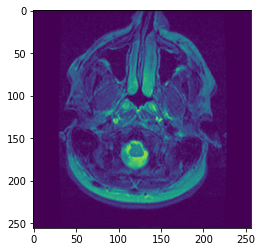

In [5]:
plt.imshow(img)

## 2d Fourier Transform

Text(0.5, 1.0, 'Fourier transform')

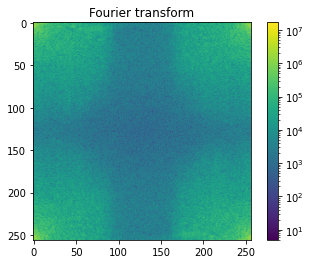

In [14]:
def plot_spectrum(im_fft):
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

im_fft = get_fourier_transform(img, fshift=False, use_absolute=False)
plot_spectrum(im_fft)
plt.title('Fourier transform')

## Inverse 2d Fourier Transform

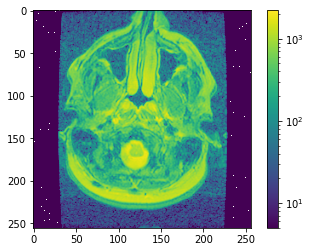

In [7]:
inverse_transform = np.fft.ifft2(im_fft)
# plt.plot(im_fft)
plot_spectrum(inverse_transform)
# plt.show()

(512, 512)
(262144, 1)
(10213,)
(10213,)


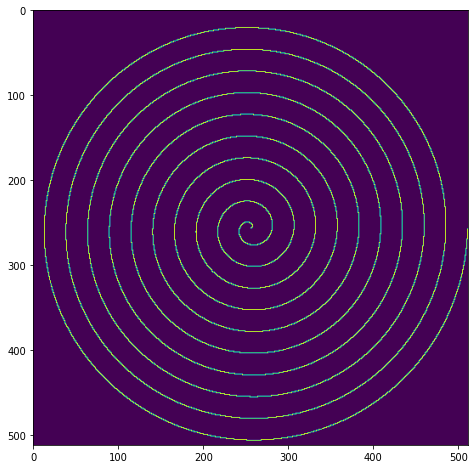

In [40]:
def spiral_samples_trajectory(width=512, 
                              height=512, 
                              starting_angle=0, 
                              n_rounds=10, 
                              r=np.linspace(0, 1, 1000000)):

    t = np.linspace(0, 1, len(r))

    for curr_angle in range(starting_angle + 1):
        x = np.cos(2 * np.pi * n_rounds * t + curr_angle) * r
        y = np.sin(2 * np.pi * n_rounds * t + curr_angle) * r

    # 0 - 511
    x = (x/2 + 0.5) * (height - 1)
    y = (y/2 + 0.5) * (width - 1)
    
    i = np.round(width - y).astype(int)
    j = np.round(x).astype(int)
    I = np.zeros((width, height))

    for k in range(len(i)):
        try:
            I[i[k],j[k]] = 1
        except Exception as e:
            print(j[k])

    I = np.fft.ifftshift(I)
    print(I.shape)

    I = np.reshape(I, [width * height, 1])
    print(I.shape)
    samples_rows = np.nonzero(I)[0]

    print(samples_rows.shape)
    samples_rows = np.sort(samples_rows)
    
    I = np.reshape(I, [width, height])

    print(samples_rows.shape)
    return samples_rows, i, j, I
    
img_size = 512
_, _, _, I =  spiral_samples_trajectory(width=img_size, height=img_size)

I = np.fft.fftshift(I)
plt.figure(figsize=(8,8))
plt.imshow(I)

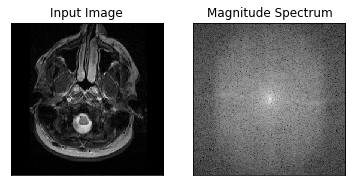

In [21]:
transformed_imgs = np.array(list(map(get_fourier_transform, data.T)))
transformed_imgs.shape

plt.subplot(121), plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(transformed_imgs[0], cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

## Plot Images Batch with Fourier Transforms

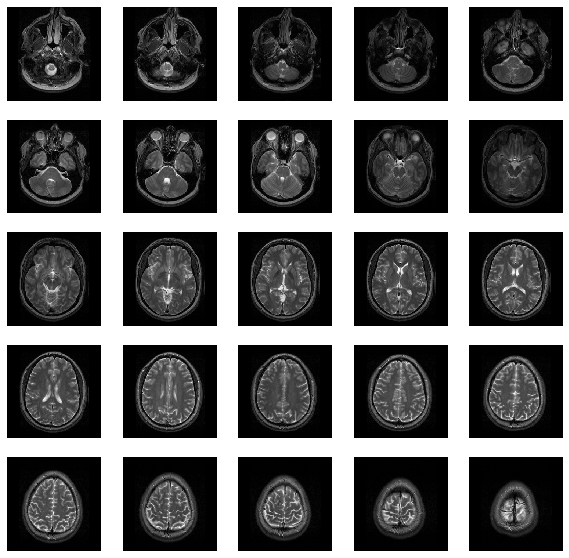

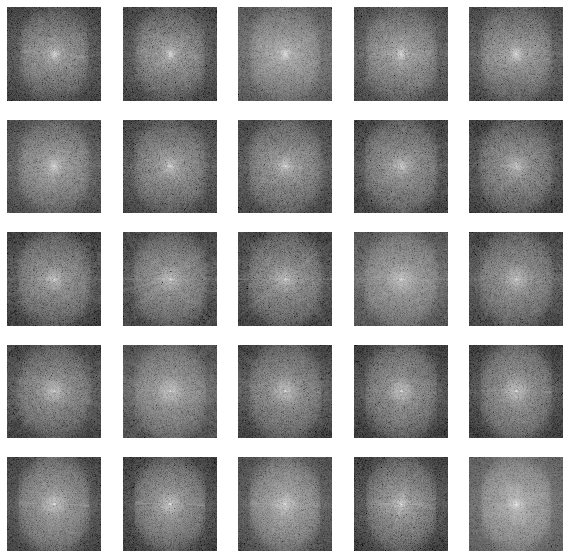

In [22]:
plot_batch(data.T)
plot_batch(transformed_imgs)

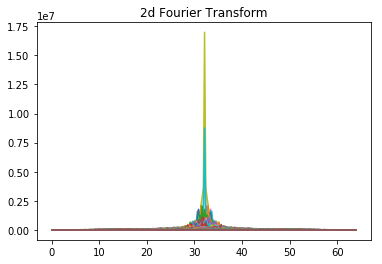

In [8]:
img = data.T[0]

def plot_2dtransform(img):
    yf = fft2(img)
    fshift = fftshift(yf)
#     yf = fshift.flatten()
    yf = fshift

    # Number of samplepoints: 512
    N = yf.shape[0]
    # sample spacing
    T = 1.0 / N * 2 

    xf = np.linspace(0.0, 1.0/(2.0 * T), yf.shape[0])
#     print(N, T, flattened.shape, xf)

    plt.plot(xf, np.abs(yf))
    plt.title("2d Fourier Transform")
    plt.show()
    
plot_2dtransform(img)

## Flatten array to 1d

In [9]:
flattened = transformed_imgs[0].flatten()
transformed_imgs[0].shape, flattened.shape

((256, 256), (65536,))

## Non-equispaced Fast Fourier Transform (NFFT)

In [10]:
x = np.arange(len(flattened))
f_k = flattened

print("Input shapes", x.shape, f_k.shape)

# non-equispaced fast Fourier transform
nfft_res = nfft(x, f_k)
nfft_res.shape, nfft_res

('Input shapes', (65536,), (65536,))


((65536,),
 array([586965.25713101+3.40955397e-10j, 586965.25713139+6.81951758e-10j,
        586965.25713064-1.36401061e-09j, ...,
        586965.22426246-7.35941128e-14j, 586965.22426246-7.35941128e-14j,
        586965.22426246-7.35941128e-14j]))

## NFFT plot

shape (256, 256)


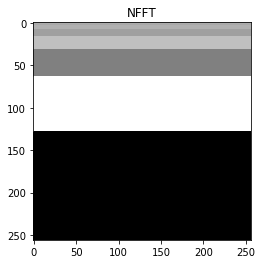

In [11]:
reshaped = nfft_res.reshape(transformed_imgs[0].shape)
# res_transform = np.fft.fft2(reshaped)
# res_transform_shift = np.fft.fftshift(reshaped)
print("shape {}".format(reshaped.shape))
res = transformed_imgs[0] = 20 * np.log(np.abs(reshaped))
plt.title('NFFT')
plt.imshow(res, cmap = 'gray')

In [12]:
print("Matrix after NFFT operation:\n\n \
    # shape {}\n \
    # of elements: {}\n \
    # of distinct elements: {}".format(res.shape, len(res.flatten()), len(set(res.flatten()))))

Matrix after NFFT operation:

     # shape (256, 256)
     # of elements: 65536
     # of distinct elements: 21
